In [45]:
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_helper import *
from utils.data import *
from utils.db import duck
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from strategy_v4.Data.Data import DataLayer
from strategy_v4.Model.run import *
from strategy_v4.Model.LinearModels import *
from strategy_v4.Model.NonLinearModels import *
from strategy_v4.Evaluate.Evaluate import Evaluate
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
instruments = [
    'META',
    'TSLA',
    'NVDA',
    'AAPL',    
    'DXJ',
    'BRK-B',
    'SPY',
    'QQQ',
    'NANC',
    'BTC',    
]
instruments = get_djia_tickers()

In [20]:
# dl_args = {key: value for key, value in vars(DATA_LAYER).items() if not key.startswith('_')}
# data = DataLayer(**dl_args)
# data.load()
# data.process()
# #data.upload()
# df = data.df

In [61]:
dl_args = {key: value for key, value in vars(DATA_LAYER).items() if not key.startswith('_')}
df = DataLayer(**dl_args).get()
df.columns

2025-02-07 20:43:39,061 - Data Layer (djia) - INFO - start_date: 2017-01-01
2025-02-07 20:43:39,063 - Data Layer (djia) - INFO - end_date: 2024-01-29
2025-02-07 20:43:39,069 - Data Layer (djia) - INFO - getting data files data/parquet/model_djia_20170101_20240129.parquet, last updated at 2025-02-07 02:55:27


Index(['date', 'asset', 'close', 'high', 'low', 'open', 'volume', 'price_rev',
       'return1d', 'return3d', 'return5d', 'return10d', 'return20d',
       'return60d', 'rsi2d', 'rsi14d', 'rsi28d', 'rsi60d', 'std5d', 'std10d',
       'std20d', 'std60d', 'volume1d', 'volume3d', 'volume5d', 'volume10d',
       'volume20d', 'volume60d'],
      dtype='object')

# Try to use price to generate more non-linear combination of features

In [99]:
#df_pred, models = run_once('Lasso', instruments)
df_pred, models = run_this(Lasso(**{'alpha': 0.001}), features=['return1d', 'close'], assets=instruments, label_name='return1d', label_shift=-1, preprocess=StandardScaler())

eval = Evaluate(asset_level=True)
eval.load(df_pred=df_pred)
eval.eval()
df_eval_asset = eval.df_eval_asset
df_eval = eval.df_eval

2025-02-07 20:51:21,547 - Data Layer (djia) - INFO - start_date: 2017-01-01
2025-02-07 20:51:21,548 - Data Layer (djia) - INFO - end_date: 2024-01-29
2025-02-07 20:51:21,549 - Data Layer (djia) - INFO - getting data files data/parquet/model_djia_20170101_20240129.parquet, last updated at 2025-02-07 02:55:27
100%|██████████| 30/30 [00:00<00:00, 114.12it/s]
/Users/lok419/Desktop/JupyterLab/Trading/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lok419/Desktop/JupyterLab/Trading/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

In [102]:
df_eval_asset[df_eval_asset['pred_type'] == 'out-sample']

,pred_type,model,asset,r2,mse,mae,accuracy_score,up_recall,up_precision,up_f1_score,down_recall,down_precision,down_f1_score
30,out-sample,custom,AAPL,-0.008870,0.000264,0.011879,0.517442,0.900000,0.522581,0.661224,0.098160,0.470588,0.162437
31,out-sample,custom,AMGN,-0.006739,0.000180,0.009957,0.482558,0.771605,0.469925,0.584112,0.225275,0.525641,0.315385
32,out-sample,custom,AMZN,0.000213,0.000515,0.016860,0.511628,1.000000,0.511628,0.676923,0.000000,0.000000,0.000000
33,out-sample,custom,AXP,-0.002517,0.000300,0.012659,0.494186,0.862069,0.500000,0.632911,0.117647,0.454545,0.186916
34,out-sample,custom,BA,-0.001501,0.000443,0.015001,0.552326,0.580311,0.605405,0.592593,0.513333,0.484277,0.498382
35,out-sample,custom,CAT,-0.002794,0.000335,0.013393,0.534884,1.000000,0.534884,0.696970,0.000000,0.000000,0.000000
36,out-sample,custom,CRM,-0.005099,0.000448,0.015117,0.508721,0.859459,0.526490,0.652977,0.100629,0.380952,0.159204
37,out-sample,custom,CSCO,-0.016683,0.000183,0.009466,0.465116,0.562162,0.502415,0.530612,0.356688,0.408759,0.380952
38,out-sample,custom,CVX,-0.013254,0.000255,0.011673,0.505814,0.670455,0.513043,0.581281,0.333333,0.491228,0.397163
39,out-sample,custom,DIS,-0.002394,0.000393,0.014051,0.488372,0.517647,0.483516,0.500000,0.467836,0.493827,0.480480


In [103]:
df_pred[df_pred['asset'] == 'AAPL'].tail(20)

,actual,pred,pred_type,asset,date
date,,,,,
2023-12-28,-0.005439,0.001036,out-sample,AAPL,2023-12-28
2023-12-29,-0.036443,0.001515,out-sample,AAPL,2023-12-29
2024-01-02,-0.007516,0.003454,out-sample,AAPL,2024-01-02
2024-01-03,-0.012781,0.001645,out-sample,AAPL,2024-01-03
2024-01-04,-0.004021,0.001975,out-sample,AAPL,2024-01-04
2024-01-05,0.023887,0.001427,out-sample,AAPL,2024-01-05
2024-01-08,-0.002266,-0.000319,out-sample,AAPL,2024-01-08
2024-01-09,0.005655,0.001317,out-sample,AAPL,2024-01-09
2024-01-10,-0.003228,0.000822,out-sample,AAPL,2024-01-10


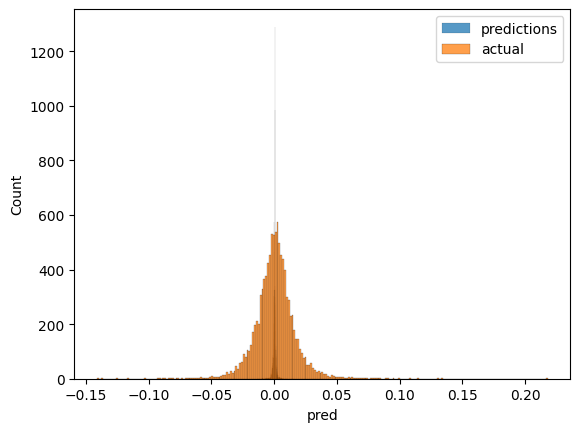

In [104]:
df_pred = eval.df_pred
df_pred_new = df_pred[df_pred['pred_type'] == 'out-sample']
sns.histplot(df_pred_new['pred'], label='predictions')
sns.histplot(df_pred_new['actual'], label='actual')
plt.legend()

In [ ]:
# eval = Evaluate(asset_level=False)
# eval.load()
# eval.eval()
# eval.df_eval

In [ ]:
db = duck("return_predictions")
db.list_tables()

In [ ]:
db.query("""--sql         
    select         
        model
        , r2
        , mse
        , mae
        , accuracy_score
        , up_recall
        , up_precision
        , up_f1_score
        , down_recall
        , down_precision
        , down_f1_score        
        , time         
        , features
        , dataset
    from model_eval
    where 1=1
    and pred_type = 'out-sample'
    and time = (select max(time) from model_eval)
    order by model
""")

In [27]:
# db.query("""--sql         
#     select    
#         model
#         , asset
#         , r2
#         , mse
#         , mae
#         , accuracy_score
#         , up_recall
#         , up_precision
#         , up_f1_score
#         , down_recall
#         , down_precision
#         , down_f1_score     
#         , time                  
#     from model_eval_asset
#     where 1=1
#     and pred_type = 'out-sample'
#     and time = (select max(time) from model_eval_asset)
#     order by asset
# """)